In [69]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import cv2

In [8]:
from sklearn.metrics import accuracy_score

def KNN_best_params(X_train: np.ndarray, X_test: np.ndarray, y_train: np.ndarray, y_test: np.ndarray):
    knn = KNeighborsClassifier()

    param_grid = {
        'n_neighbors': list(range(1, 75)),
        # 'weights': ['uniform', 'distance'],
        # 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        # 'p': [1, 2],
    }

    grid_search_knn = GridSearchCV(knn, param_grid, cv=5, scoring="accuracy")  # 5-fold cross-validation
    grid_search_knn.fit(X_train, y_train)

    y_pred_train = grid_search_knn.predict(X_train)
    y_pred_test = grid_search_knn.predict(X_test)

    best_model_config = grid_search_knn.best_params_
    max_train_score = accuracy_score(y_train, y_pred_train)
    max_test_score = accuracy_score(y_test, y_pred_test)

    return [max_train_score, max_test_score, best_model_config]

# Iris Dataset

In [14]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#### Model Training on normal data

In [15]:
KNN_best_params(X_train, X_test, y_train, y_test)

[0.975, 0.9666666666666667, {'n_neighbors': 11}]

#### PCA analysis

Optimal value of k: 2


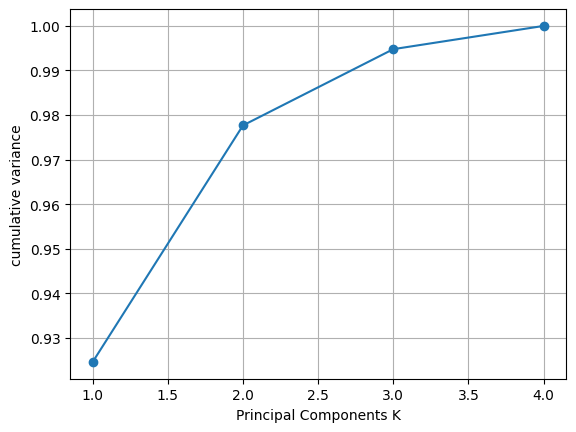

In [29]:
pca = PCA()

pca.fit(X)

var_threshold = 0.95
variance_ratios = pca.explained_variance_ratio_
cum_variance_ratios = np.cumsum(variance_ratios)

optimal_k = np.argmax(cum_variance_ratios >= var_threshold) + 1
print(f"Optimal value of k: {optimal_k}")

plt.plot(range(1, len(cum_variance_ratios) + 1), cum_variance_ratios, marker='o')
plt.xlabel('Principal Components K')
plt.ylabel('cumulative variance')
plt.grid(True)
plt.show()


In [35]:
pca = PCA(n_components=1)
reduced_X = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(reduced_X, y, test_size=0.2, random_state=1)

In [36]:
KNN_best_params(X_train, X_test, y_train, y_test)

[0.9416666666666667, 0.9666666666666667, {'n_neighbors': 42}]

<!-- perform pca -->

# Custom Dataset

In [36]:
import numpy as np
import os
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import pandas as pd

#### Extract Data

In [4]:
import os


path = "./Dataset/Soil types/"
subpaths = os.listdir(path)

for i in subpaths:
    print(os.listdir(path + i))


['10.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg', '17.jpg', '18.jpg', '19.jpg', '2.jpg', '20.jpg', '21.jpg', '22.jpg', '23.jpg', '24.jpg', '25.jpg', '26.jpg', '27.jpg', '28.jpg', '29.jpg', '3.jpg', '30.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg']
['10.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg', '17.jpg', '18.jpg', '19.jpg', '2.jpg', '20.jpg', '21.jpg', '22.jpg', '23.jpg', '24.jpg', '25.jpg', '26.jpg', '27.jpg', '28.jpg', '29.jpg', '3.jpg', '30.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg']
['10.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg', '17.jpg', '18.jpg', '19.jpg', '2.jpg', '20.jpg', '21.jpg', '22.jpg', '23.jpg', '24.jpg', '25.jpg', '26.jpg', '27.jpg', '28.jpg', '29.jpg', '3.jpg', '30.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg']
['10.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg', '17.jpg', '18.jpg', '19.jpg', '2.jpg', '20.jpg', '21.jpg', '22.jpg', '23.jpg', '

In [49]:
black_image_path = "./Dataset/Soil types/BlackSoil/"
black_dump_path = "./Dataset/Resized/BlackSoil/"

laterite_image_path = "./Dataset/Soil types/LateriteSoil/"
laterite_dump_path = "./Dataset/Resized/LateriteSoil/"
# final_size = (645, 1032)
final_size = (256, 256)

In [58]:
def extract_sift_features(image):
    sift = cv2.SIFT_create()
    key_points, descriptors = sift.detectAndCompute(image, None)
    return key_points, descriptors

In [4]:
def resizeImage(image: np.ndarray, size: tuple) -> np.ndarray:
    return cv2.resize(image, size, interpolation=cv2.INTER_AREA)

def extractFileName(fileName: str) -> str:
    return ('.'.join(fileName.split(".")[:-1]))

In [51]:
def resizeAndDump(readPath: str, WritePath: str):
    for file_name in os.listdir(readPath):
        file_path = readPath + "/" + file_name
        file_name_without_extension = extractFileName(file_name)
        try:
            img_arr = np.asarray(Image.open(file_path))
        except Exception as e:
            print(file_path, e)
            continue
        resized_img_arr = resizeImage(img_arr, final_size)
        print(resized_img_arr)
        plt.imsave(f"{WritePath}{file_name_without_extension}.png", resized_img_arr)

In [ ]:
resizeAndDump(black_image_path, black_dump_path)
resizeAndDump(laterite_image_path, laterite_dump_path)

print(len(os.listdir(black_dump_path)))
print(len(os.listdir(laterite_dump_path)))

In [38]:
def generateDescriptorHistograms(paths: list, labels: list, KMeansModel: KMeans, cluster_size: int) -> pd.DataFrame:
    pca = PCA(n_components=77) 
    data = []
    _max = 0

    # process plain images
    for i in range(len(paths)):
        for image_path in paths[i]:
            # read image array grayscale color space
            img_arr = cv2.imread(image_path, 0)

            # extract descriptors from image
            keypoints, descriptor = extract_sift_features(img_arr)

            if(descriptor.shape[0]) < 77:
                # print(image_path)
                continue

            # do pca on descriptors
            reduced_descriptors = pca.fit_transform(descriptor)

            # generate image descriptor classes
            class_labels = KMeansModel.predict(reduced_descriptors)

            # initialize and populate histogram with 115 descriptor classes
            histogram = np.zeros(cluster_size, dtype=int)
            histogram_cropped = np.bincount(class_labels)
            histogram[:len(histogram_cropped)] = np.logical_or(histogram_cropped,histogram[:len(histogram_cropped)]) * histogram_cropped

            # store data
            data.append({"Path":image_path, "Desc_Histogram":histogram, "Class":labels[i]})
    
    df = pd.DataFrame(data)
    return df

In [61]:
Black_processed = [(black_dump_path + black_path) for black_path in os.listdir(black_dump_path)]
Laterite_processed = [(laterite_dump_path + laterite_path) for laterite_path in os.listdir(laterite_dump_path)]

def extract_descriptor_data() -> pd.DataFrame:
    data = []

    for i in Black_processed:
        img_arr = cv2.imread(i, 0)
        keypoints, descriptor = extract_sift_features(img_arr)
        for i in descriptor:
            descriptorData = {"Vector": i, "Class": 0}
            data.append(descriptorData)

    for i in Laterite_processed:
        img_arr = cv2.imread(i, 0)
        keypoints, descriptor = extract_sift_features(img_arr)
        for i in descriptor:
            descriptorData = {"Vector": i, "Class": 1}
            data.append(descriptorData)
    
    df = pd.DataFrame(data)
    return df

In [62]:
descriptor_df = extract_descriptor_data()

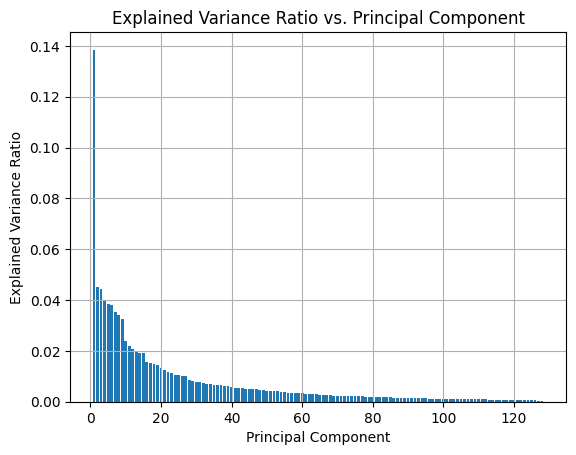

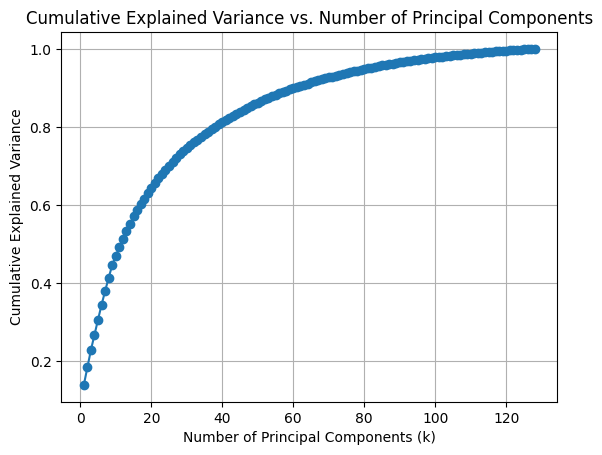

Optimal value of k: 81


In [70]:
# Assuming your descriptors are stored in a NumPy array 'descriptors' with shape (353561, 128).

# Create an instance of PCA
pca = PCA()

# Fit PCA to your descriptors
pca.fit(np.vstack(descriptor_df["Vector"]))

# Calculate the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot the explained variance ratio for each principal component
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Principal Component')
plt.grid(True)
plt.show()

# Plot the cumulative explained variance
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='-')
plt.xlabel('Number of Principal Components (k)')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Principal Components')
plt.grid(True)
plt.show()

desired_explained_variance = 0.95

# Find the smallest k that achieves the desired explained variance
optimal_k = np.argmax(cumulative_explained_variance >= desired_explained_variance) + 1

print(f"Optimal value of k: {optimal_k}")

In [71]:
from sklearn.decomposition import PCA

pca = PCA(n_components=77)

reduced_descriptors = pca.fit_transform(np.vstack(descriptor_df["Vector"]))

In [72]:
np.save("reduced_descriptors", reduced_descriptors)

## Clustering

In [73]:
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import numpy as np
import json
import pickle

In [75]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(5, 215, 10)

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(reduced_descriptors)
    pickle.dump(kmeanModel, open(f"./ClusteringModels/PCA//kmeans_{k}.pickle", "wb"))
 
    distortions.append(sum(np.min(cdist(reduced_descriptors, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / reduced_descriptors.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(reduced_descriptors, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / reduced_descriptors.shape[0]
    mapping2[k] = kmeanModel.inertia_
    if(k%15 == 0):   
        print(k)

c:\Users\devbh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\devbh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


15


c:\Users\devbh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\devbh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "c:\Users\devbh\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\multiarray.py", line 346, in where
    @array_function_from_c_func_and_dispatcher(_multiarray_umath.where)
    
KeyboardInterrupt: 
c:\Users\devbh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
